# Assignment 3

## Guidelines

> Remember to add an explanation of what you do using markdown, and to comment your code. Please *be brief*.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> Make sure your notebooks have been run when you sumit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.

## Grading policy
> As follows:
>
> * 80 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious.
> 
> Note that there are no extras for this assignment, as all 100 points are accrued via questions. 

**The AUC code of conduct applies to this assignment: please only submit your own work.**

---

# Introduction

In this assignment, you will build and compare classifiers for measuring the **sentiment of tweets related to COVID-19**.

The dataset you will work with is [publicly available in Kaggle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) (and attached to the assignment for your convenience). Make sure to check its minimal Kaggle documentation before starting.

This is a real dataset, and therefore messy. It is possible that you won't achieve great results on the classification task with your classifier. That is normal, don't worry about it! You also may find text encoding issues with this dataset. Try to find a simple solution to this problem, I don't think there is an easy way to fix it completely for these files.

*Please note: this dataset should not but might contain content which could be considered as offensive.*

---

# Skeleton pipeline (25 points)

## Question 1 (10 points)

Your dataset contains tweets, including handlers, hashtags, URLs, etc. Set-up a **minimal pre-processing pipeline** for them (focus on the `OriginalTweet` column), possibly including:

* Tokenization
* Filtering
* Lemmatization/Stemming

Please note that what to include is up to you, motivate your choices and remember that more is not necessarily better: if you are not sure why you are doing something, it might be better not to. Feel free to use NLTK, spaCy or anything else you like here.

In [1]:
import pandas as pd

In [6]:
df_train = pd.read_csv("data/Corona_NLP_train.csv", encoding='ISO-8859-1')

In [7]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


*Note: we only really use the `OriginalTweet` and `Sentiment` columns for this assignment.*

In [93]:
# your code here

# % pip install PyDictionary

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tweets = list(zip(df_train["OriginalTweet"], df_train["Sentiment"]))

regextk = RegexpTokenizer('\s+', gaps=True)

tokens = [(regextk.tokenize(tweet), sentiment) for tweet, sentiment in tweets]

filtered_tweets = []
for tweet in tokens:
    newtweet = []
    for word in tweet[0]:
        # dropping @-tags and links
        if not ('@' in word or 'https' in word):
            newtweet.append(word.lower())
    
    # dropping tweets with less than 5 words
    if len(newtweet) > 5:
        filtered_tweets.append((newtweet, tweet[1]))

tagged = [(nltk.pos_tag(tweet), sentiment) for tweet, sentiment in filtered_tweets]

tagged[1]

([('coronavirus', 'NN'),
  ('australia:', 'VBZ'),
  ('woolworths', 'NNS'),
  ('to', 'TO'),
  ('give', 'VB'),
  ('elderly,', 'NN'),
  ('disabled', 'VBN'),
  ('dedicated', 'VBD'),
  ('shopping', 'NN'),
  ('hours', 'NNS'),
  ('amid', 'IN'),
  ('covid-19', 'JJ'),
  ('outbreak', 'NN')],
 'Positive')

In [94]:
import string
from nltk.corpus import wordnet as wn

def wn_pos(tag):
    "converts treebank tags into wordbank tags for lemmatization"
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return None

lem_tweets = []
lem = WordNetLemmatizer()

for tweet in tagged:
    lemmas = []
    
    for word, tag in tweet[0]:
        wn_tag = wn_pos(tag)
        
        if word[-1] in string.punctuation:
                word = word[:-1]
    
        # drop non-tagged words
        if wn_pos(tag) is not None:
            # append lemmatized word to list using PoS tag for more accurate lemmatization
            lemmas.append(lem.lemmatize(word, wn_tag))
                
    lem_tweets.append((lemmas, tweet[1]))

lemmas = [lem for tweet in lem_tweets for lem in tweet]

lem_tweets[1]

(['coronavirus',
  'australia',
  'woolworth',
  'give',
  'elderly',
  'disable',
  'dedicate',
  'shopping',
  'hour',
  'covid-19',
  'outbreak'],
 'Positive')

In [98]:
joined_lem_tweets = []
for tweet in lem_tweets:
    joined_lem_tweets.append((" ".join(tweet[0]), tweet[1]))
    
lem_df = pd.DataFrame(joined_lem_tweets, columns=["Tweet", "Sentiment"])
lem_df.sample(5)

,Tweet,Sentiment
22676,dollar #saraimrieart #covid_19 #coronavirus #t...,Neutral
1132,y'all this one ever look down grocery store wo...,Positive
38402,i haven t fill tank week russia need do bc low...,Extremely Negative
36931,sanitizer italy wuhan grocery join,Positive
6446,new report deloitte #china chain store &amp fr...,Negative


---

## Question 2 (5 points)

**Split your data into a train and a validation set**. You can use 85% for training and 15% for validation, or similar proportions. Remember to shuffle your data before splitting, specifying a seed to be able to replicate your results.

In [178]:
# your code here

from sklearn.model_selection import train_test_split

seed = 69

train = lem_df.sample(frac=.85, random_state=seed)

val = lem_df.drop(train.index)

---

## Question 3 (10 points)

Write a function which, given as input a set of predictions and a set of ground truth labels, prints out a **classification report** including:
* Name of the method
* Accuracy
* Precision, recall and F1 measure
* An example of a correctly classified datapoint
* An example of a wrongly classified datapoint

In [224]:
# your code here

from sklearn.metrics import precision_score, recall_score, f1_score

def class_report(clf, preds, truths, df):
    print("Method:", clf)
    print("Accuracy:", np.mean(preds == truths))
    print("Precision:", precision_score(preds, truths, average="weighted"))
    print("Recall:", recall_score(preds, truths, average="weighted"))
    print("F1 Score:", f1_score(preds, truths, average="weighted"))
    
    correct = 
    print("Correctly classified tweet:", )

---

# Classifying (55 points)

## Question 4 (15 points)

An important first step when dealing with a real-world task is establishing a **solid baseline**. The baseline allows to a) develop the first full pipeline for your task, and b) to have something to compare against when you develop more advanced models.

Pick a method to use as a baseline. *A good option might be a TF-IDF Logistic Regression*. Feel free to use scikit-learn or another library of choice. See [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for more options.

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*

In [177]:
# your code here

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

count = CountVectorizer()
train_counts = count.fit_transform(train["Tweet"])

tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_counts)

In [227]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB().fit(train_tfidf, train["Sentiment"])

val_counts = count.transform(val["Tweet"])
val_tfidf = tfidf_transformer.transform(val_counts)

mnb_pred = MNB.predict(val_tfidf)

NB_df = pd.DataFrame(zip(test["Tweet"], mnb_pred, test["Sentiment"]), columns=["Tweet", "Predicted", "Actual"])

display(NB_df)

print("Sentiment prediction accuracy:", np.mean(pred == val["Sentiment"]))

,Tweet,Predicted,Actual
0,advice talk neighbour family exchange phone nu...,Positive,Positive
1,coronavirus australia woolworth give elderly d...,Positive,Positive
2,food stock be not only be empty.. please don't...,Positive,Positive
3,me ready go supermarket #covid19 not i'm paran...,Positive,Extremely Negative
4,news regionâs first confirm covid-19 case com...,Positive,Positive
...,...,...,...
6121,food system amp food supply be be test situati...,Negative,Extremely Positive
6122,work #consumergoods be #coronavirus affect bus...,Positive,Positive
6123,u.s covid sniper strange american italy covid-...,Positive,Negative
6124,? consumer india's major city be rush stock up...,Positive,Negative


Sentiment prediction accuracy: 0.38573294156056154


---

## Question 5 (25 points)

Try now to **beat your baseline**. Feel free to use scikit-learn or another library of choice. See [here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) for more options.

How to beat the baseline? There are many ways:
1. You could have a better text representation (e.g., using PPMI instead of TF-IDF, note that this is challenging because there is no ready-made scikit-learn vectorizer for this).
2. You can pick a more powerful model (e.g., random forests or SVMs).
3. You have to find good hyperparameters for your model, and not just use the default ones.

Regarding point 3 above, make sure to perform some hyperparameter searching using [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [randomized search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*

In [184]:
# your code here

from sklearn.ensemble import RandomForestClassifier
    
rfc = RandomForestClassifier().fit(train_tfidf, train["Sentiment"])

rfc_pred = rfc.predict(val_tfidf)

In [242]:
clf_df = pd.DataFrame(zip(test["Tweet"], pred, rfc_pred, test["Sentiment"]), 
                     columns=["Tweet", "Multinomial NB", "Random Forest", "Actual"])

display(clf_df)

print("Sentiment prediction accuracy:\n", 
      "\nMultinomial Naive Bayes:", np.mean(pred == val["Sentiment"]), 
      "\nRandom Forest:", np.mean(rfc_pred == val["Sentiment"]))

,Tweet,Multinomial NB,Random Forest,Actual
0,advice talk neighbour family exchange phone nu...,Positive,Extremely Positive,Positive
1,coronavirus australia woolworth give elderly d...,Positive,Positive,Positive
2,food stock be not only be empty.. please don't...,Positive,Positive,Positive
3,me ready go supermarket #covid19 not i'm paran...,Positive,Neutral,Extremely Negative
4,news regionâs first confirm covid-19 case com...,Positive,Extremely Negative,Positive
...,...,...,...,...
6121,food system amp food supply be be test situati...,Negative,Extremely Negative,Extremely Positive
6122,work #consumergoods be #coronavirus affect bus...,Positive,Positive,Positive
6123,u.s covid sniper strange american italy covid-...,Positive,Neutral,Negative
6124,? consumer india's major city be rush stock up...,Positive,Positive,Negative


Sentiment prediction accuracy:
 
Multinomial Naive Bayes: 0.38573294156056154 
Random Forest: 0.5164871041462619


The Random Forest Classifer takes much longer to train than the Multinomial Naive Bayes used previously, but does provide signifcantly better predictions even without altering the hyperparameters or changing the text representation

In [235]:
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [236]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(1, 20, 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

rscv = RandomizedSearchCV(rfc, random_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=seed)
search = rscv.fit(train_tfidf, train["Sentiment"])
search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 18,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 120,
 'bootstrap': False}

In [241]:
rfc_opt = RandomForestClassifier(n_estimators=18,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='auto',
                                 max_depth=120,
                                 bootstrap=False).fit(train_tfidf, train["Sentiment"])

rfc_opt_pred = rfc_opt.predict(val_tfidf)

In [258]:
clf_df = pd.DataFrame(zip(test["Tweet"], pred, rfc_pred, rfc_opt_pred, test["Sentiment"]), 
                     columns=["Tweet", "Multinomial NB", "Random Forest", "Opitmised RFC", "Actual"])

display(clf_df)

print("Sentiment prediction accuracy:\n", 
      "\nMultinomial Naive Bayes:", np.mean(pred == val["Sentiment"]), 
      "\nRandom Forest:", np.mean(rfc_pred == val["Sentiment"]),
      "\nOptimised RFC:", np.mean(rfc_opt_pred == val["Sentiment"]))

,Tweet,Multinomial NB,Random Forest,Opitmised RFC,Actual
0,advice talk neighbour family exchange phone nu...,Positive,Extremely Positive,Extremely Positive,Positive
1,coronavirus australia woolworth give elderly d...,Positive,Positive,Positive,Positive
2,food stock be not only be empty.. please don't...,Positive,Positive,Negative,Positive
3,me ready go supermarket #covid19 not i'm paran...,Positive,Neutral,Neutral,Extremely Negative
4,news regionâs first confirm covid-19 case com...,Positive,Extremely Negative,Extremely Negative,Positive
...,...,...,...,...,...
6121,food system amp food supply be be test situati...,Negative,Extremely Negative,Extremely Negative,Extremely Positive
6122,work #consumergoods be #coronavirus affect bus...,Positive,Positive,Positive,Positive
6123,u.s covid sniper strange american italy covid-...,Positive,Neutral,Neutral,Negative
6124,? consumer india's major city be rush stock up...,Positive,Positive,Positive,Negative


Sentiment prediction accuracy:
 
Multinomial Naive Bayes: 0.38573294156056154 
Random Forest: 0.5164871041462619 
Optimised RFC: 0.5021221025138752


The best parameters found by the randomized search seem to actually give worse accuracy. Not sure what's up here

---

## Question 6 (15 points)

Design, develop and train a (simple!) **neural network-based classifier** for this task, using scikit-learn or PyTorch. The classifier can have the structure that you prefer, just make sure to motivate your choices. If in doubt, try with a bag of embeddings classifier.

*Note: an NN-based classifier with scikit-learn yields 5 points max; one with PyTorch yields 10 points max; one with PyTorch and pre-trained embeddings yields 15 points max.*

Use your classification report function and the validation set to report on the performance of your baseline. *Pay attention: the validation data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed it, use the same fitted vectorizer to transform your validation data.*s

In [194]:
# your code here

import torch
import torch.nn as nn
import torch.nn.functional as F

---

# Evaluating your classifiers (20 points)

## Question 7 (10 points)

Evaluate the performance of your models on the **test set**. Make sure to transform your test data as you did for your train data, and as needed for each classifier. *Pay attention: the test data only needs to be transformed, and must not be used to fit any transformation. For example, if you have used a TF-IDF vectorizer by fitting it to your train data and then transformed your train and validation with it, use the same fitted vectorizer to transform your test data.*

* Report the accuracy of each classifier, as well as its precision, recall and F1 score. 
* Plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for your best classifier.
* Briefly discuss your results.

In [196]:
df_test = pd.read_csv("data/Corona_NLP_test.csv")

In [201]:
# your code here

# exact same procedure as before to transform data

test_tweets = list(zip(df_test["OriginalTweet"], df_test["Sentiment"]))

test_tokens = [(regextk.tokenize(tweet), sentiment) for tweet, sentiment in test_tweets]

filtered_test_tweets = []
for tweet in test_tokens:
    newtweet = []
    for word in tweet[0]:
        if not ('@' in word or 'https' in word):
            newtweet.append(word.lower())
    
    if len(newtweet) > 5:
        filtered_test_tweets.append((newtweet, tweet[1]))

test_tagged = [(nltk.pos_tag(tweet), sentiment) for tweet, sentiment in filtered_test_tweets]

test_lem_tweets = []

for tweet in test_tagged:
    lemmas = []
    
    for word, tag in tweet[0]:
        wn_tag = wn_pos(tag)
        
        if word[-1] in string.punctuation:
                word = word[:-1]
    
        if wn_pos(tag) is not None:
            lemmas.append(lem.lemmatize(word, wn_tag))
                
    test_lem_tweets.append((lemmas, tweet[1]))
    
test_joined = []
for tweet in test_lem_tweets:
    test_joined.append((" ".join(tweet[0]), tweet[1]))
    
test = pd.DataFrame(joined_lem_tweets, columns=["Tweet", "Sentiment"])
test.sample(5)

,Tweet,Sentiment
40795,donât see grocery store owner blow off steam ...,Neutral
1512,friend come back overseas be tell self isolate...,Positive
14360,very silly teen cough grocery store produce ne...,Negative
13582,preach daily good deed be really show true col...,Extremely Positive
16502,day day isolation child build castle toilet pa...,Negative


In [251]:
def new_class_report(clf, preds, truths):
    print("Method:", clf)
    print("Accuracy:", np.mean(preds == truths))
    print("Precision:", precision_score(preds, truths, average="weighted"))
    print("Recall:", recall_score(preds, truths, average="weighted"))
    print("F1 Score:", f1_score(preds, truths, average="weighted"))

In [252]:
test_counts = count.transform(test["Tweet"])
test_tfidf = tfidf_transformer.transform(test_counts)

clfs = [rfc, MNB, rfc_opt]

for clf in clfs:
    clf_pred = clf.predict(test_tfidf)
    new_class_report(clf, clf_pred, test["Sentiment"])
    print("\n")

Method: RandomForestClassifier()
Accuracy: 0.9273751224289912
Precision: 0.9280592333237292
Recall: 0.9273751224289912
F1 Score: 0.9272915099088903


Method: MultinomialNB()
Accuracy: 0.49657198824681686
Precision: 0.8046034428654657
Recall: 0.49657198824681686
F1 Score: 0.5660332845213777


Method: RandomForestClassifier(bootstrap=False, max_depth=120, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=18)
Accuracy: 0.6672135161606269
Precision: 0.699939100897345
Recall: 0.6672135161606269
F1 Score: 0.6686920892652245




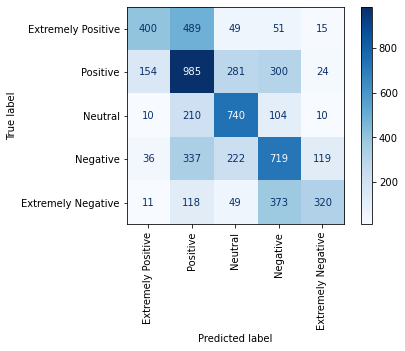

In [257]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(val["Sentiment"], 
                                        rfc_pred, 
                                        cmap=plt.cm.Blues, 
                                        xticks_rotation=90, 
                                        labels=['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'])
plt.show()

---

## Question 8 (10 points)

When the results of two models are similar, and anyway as a good practice, you may want to test whether their results **differ significantly**. If you can afford to do multiple paired runs of both models on different slices of the data (or different samples), a good approach is the [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html).

* Select two (or more) of your classifiers which have somewhat similar results on your validation data. Make sure to select two methods which do not take too long to run.
* Merge your train and validation data, and implement a function to shuffle and sample a % of datapoints (with labels) from it.
* Iterate 5-10 times the following steps:
   - Shuffle and sample 80% of your training datapoints.
   - Train instances of the two classifiers on the same 80% sample.
   - Assess their accuracy on the test dataset and store these results (into two separate lists for each classifier).
* Perform a Wilcoxon test on these results and discuss whether the two classifiers are significantly different on this task and dataset.

In [267]:
# your code here

merged = pd.concat([test, val], axis=0)

def shuff(df, pc):
    df.sample(frac=pc)
    
for

,Tweet,Sentiment
0,advice talk neighbour family exchange phone nu...,Positive
1,coronavirus australia woolworth give elderly d...,Positive
2,food stock be not only be empty.. please don't...,Positive
3,me ready go supermarket #covid19 not i'm paran...,Extremely Negative
4,news regionâs first confirm covid-19 case com...,Positive
...,...,...
40815,question be way buy sell commodity other commo...,Neutral
40823,good news we'll soon announce high tech g&amp;...,Positive
40827,do not have supermarket nearby have do get cov...,Neutral
40828,exactly be go re-open new york city still can'...,Positive


---